In [2]:
# Imports:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import os
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
sns.set_theme()
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, BatchNormalization, MaxPooling1D, Flatten
length = 277
import shap

c:\Users\alin2\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14845716763971803783
xla_global_id: -1
]


In [4]:
train_values = pd.read_csv('./data/train_test/train_beats.csv').values
test_values = pd.read_csv('./data/train_test/test_beats.csv').values

print(train_values.shape)
print(test_values.shape)

X_train = train_values[:,:-2]
X_test = test_values[:,:-2]

X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

y_train = train_values[:,-2]
y_test = test_values[:,-2]

y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

(31055, 277)
(37441, 277)


In [5]:
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Conv1D, MaxPooling1D

def getModel():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=16,padding='same', activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=32, kernel_size=16,padding='same', activation='relu'))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=9, kernel_size=16,padding='same', activation='relu',name = 'last_conv_layer'))
    cnnmodel.add(MaxPooling1D(pool_size=4,padding='same'))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(256, activation='relu'))
    cnnmodel.add(Dense(128, activation='relu'))
    cnnmodel.add(Dense(32, activation='relu'))
    cnnmodel.add(Dense(9, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    return cnnmodel

cnnmodel = getModel()
cnnmodel.summary()

cnnmodel.fit(X_train, y_train, epochs=10, verbose=1, validation_split=0.2, batch_size = 64)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 275, 128)          2176      
                                                                 
 batch_normalization (BatchN  (None, 275, 128)         512       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 275, 32)           65568     
                                                                 
 batch_normalization_1 (Batc  (None, 275, 32)          128       
 hNormalization)                                                 
                                                                 
 last_conv_layer (Conv1D)    (None, 275, 9)            4617      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 69, 9)            0

In [6]:
pred = cnnmodel.predict(X_test)
accuracy_score(np.argmax(y_test, axis = 1), np.argmax(pred, axis = 1))

1171/1171 [==============================] - 10s 8ms/step


0.9532865040997837

In [7]:
class_nums = np.arange(1, 9)
counts = [np.count_nonzero(np.argmax(y_test, axis=1) == class_num) for class_num in class_nums]
counts


[28534, 1659, 2513, 1310, 754, 189, 401, 2081]

In [8]:
for class_num in range(1, 9):
    print(f'Class {class_num} accuracy: {accuracy_score(np.argmax(y_test, axis=1) == class_num, np.argmax(pred, axis=1) == class_num)}')

Class 1 accuracy: 0.9560642076867605
Class 2 accuracy: 0.9991453219732379
Class 3 accuracy: 0.998050265751449
Class 4 accuracy: 0.9896370289255094
Class 5 accuracy: 0.9762826847573516
Class 6 accuracy: 0.9900376592505542
Class 7 accuracy: 0.99797013968644
Class 8 accuracy: 0.9993857001682648


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


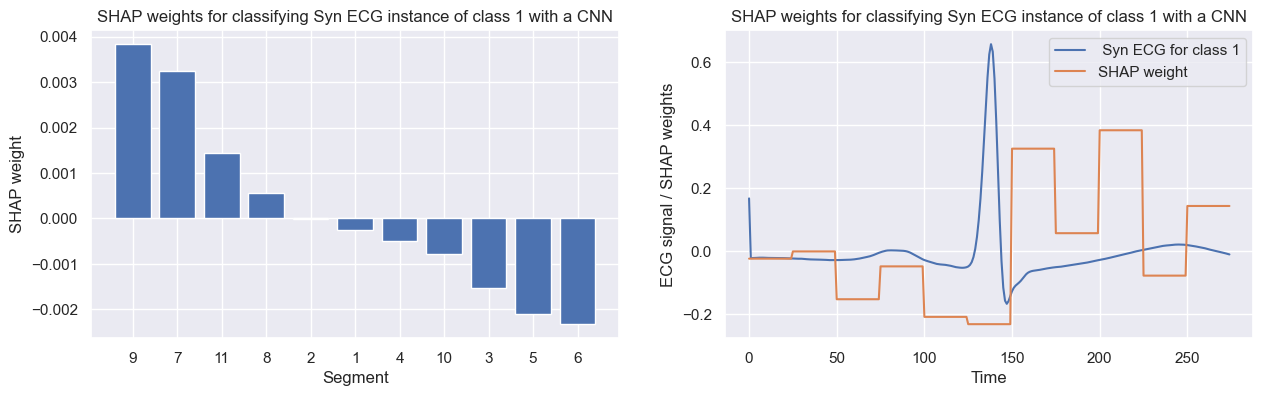

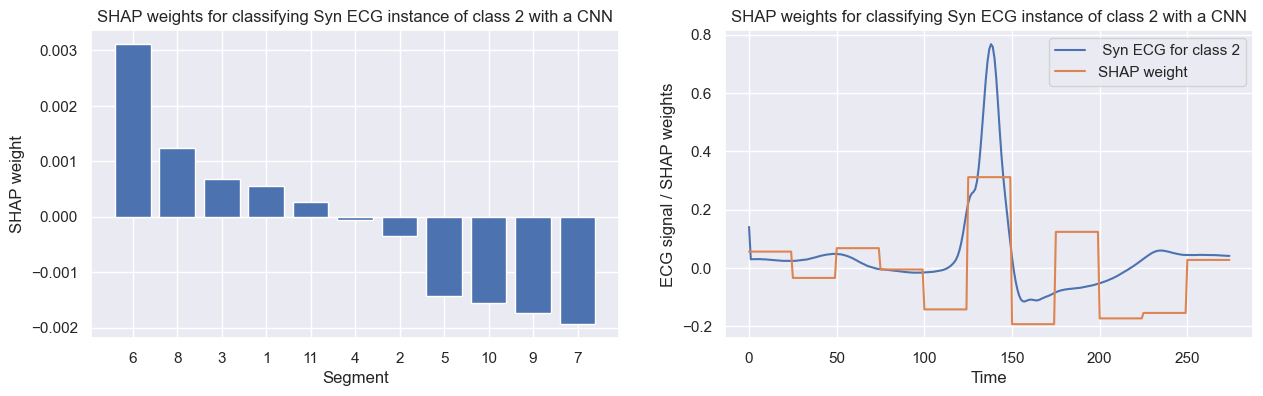

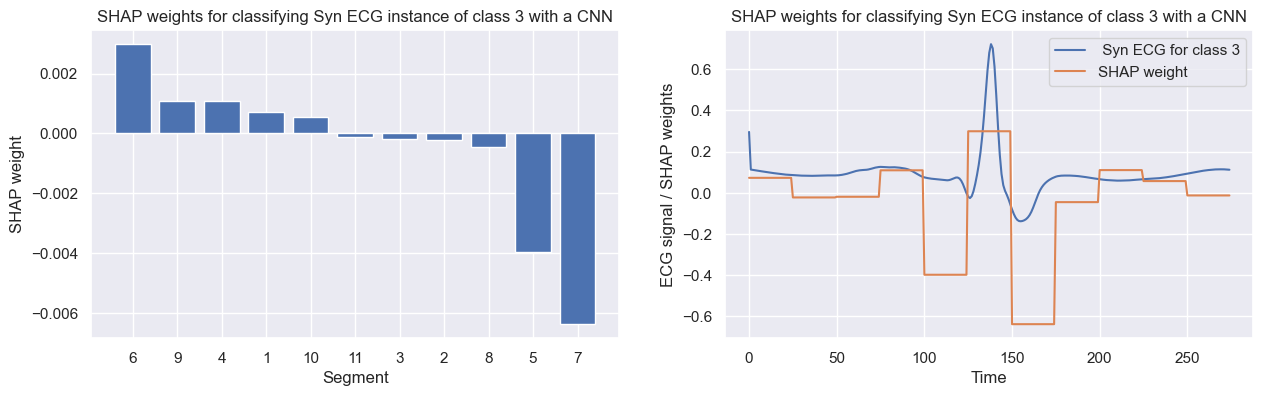

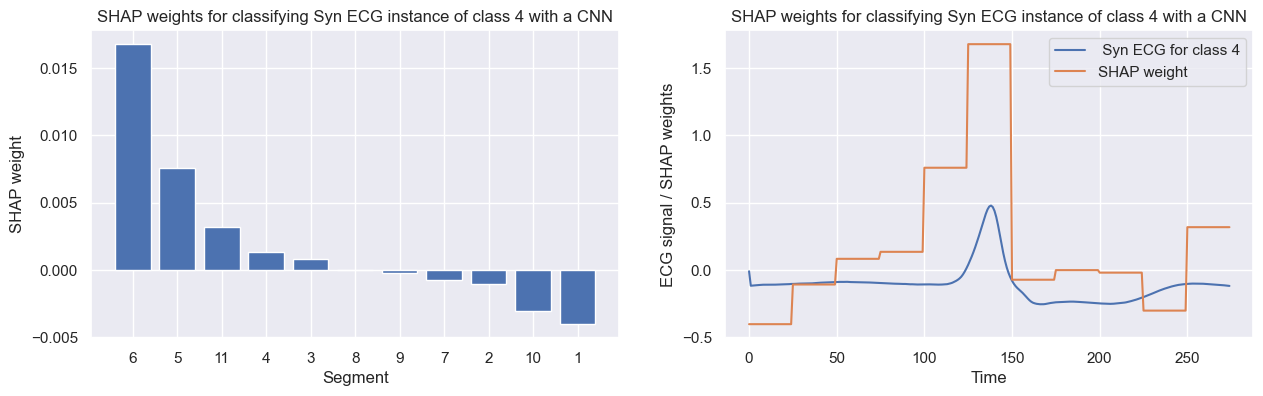

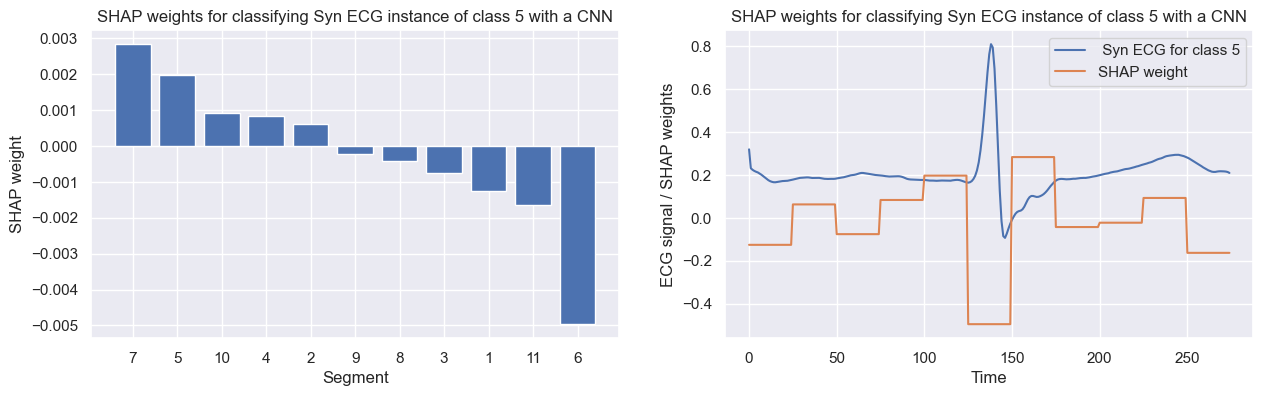

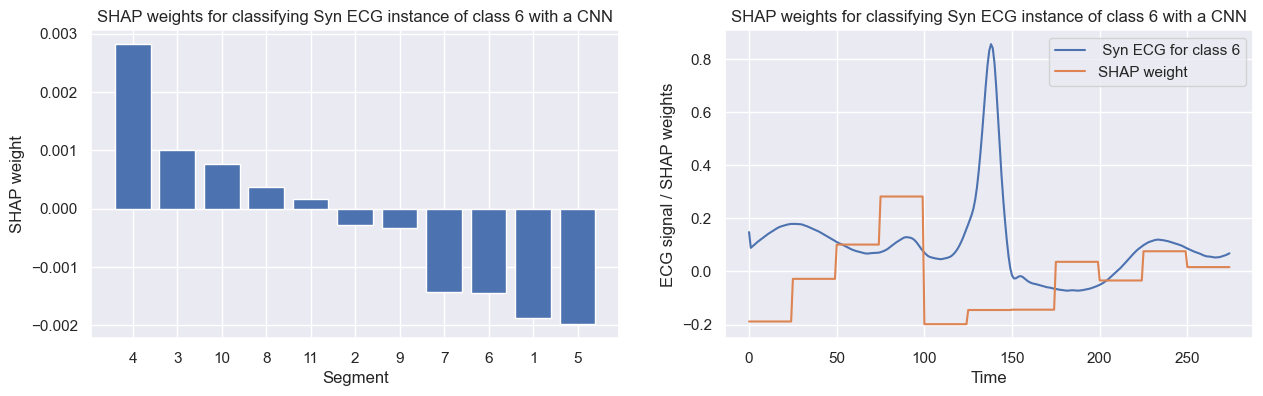

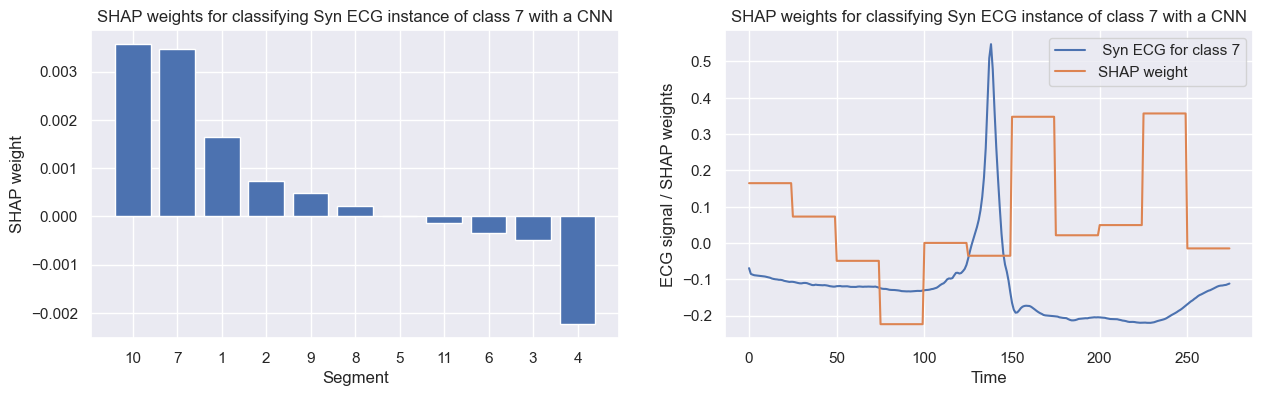

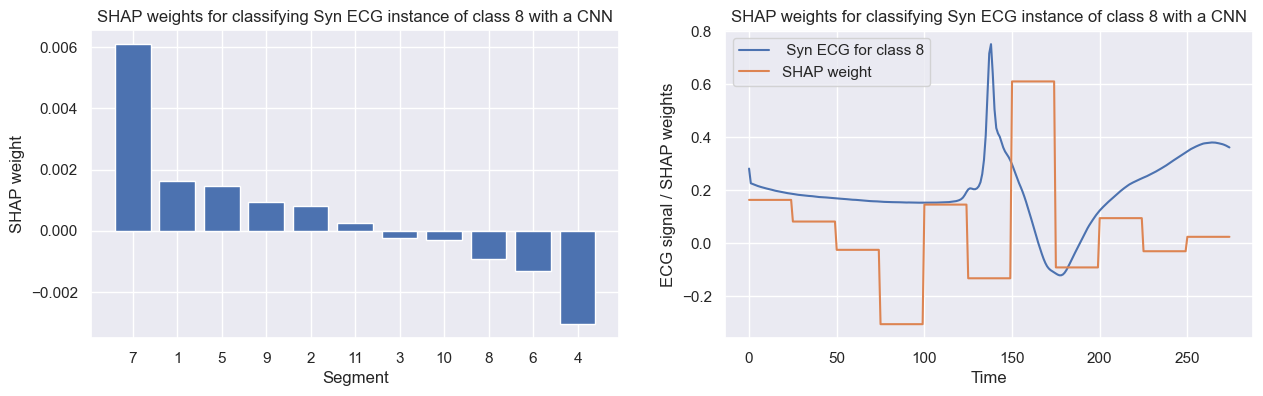

In [37]:
for class_num in range(1, 9):
    N_test = test_values[test_values[:,-2]==class_num]

    Xs_test = N_test[:,:-2]
    ys_test = N_test[:len(N_test),-2]

    Xs_test1 = Xs_test.reshape(-1, X_test.shape[1], 1)
    ys_test1 = to_categorical(ys_test)

    ecg_normalized_all = []

    for n in range (0, len(Xs_test1)):
        ecg_normalized_temp = (Xs_test1[n, :, 0] - Xs_test1[n, :, 0].min()) / (Xs_test1[n, :, 0].max() - Xs_test1[n, :, 0].min())
        ecg_normalized_all.append(ecg_normalized_temp)
    ecg_normalized_all = np.array(ecg_normalized_all)

    ecg_class_mean = np.mean(ecg_normalized_all, axis=0)
    # Ensure that the reshaping of ecg_class_mean matches the expected input shape for shap_values
    ecg_class_mean_s = ecg_class_mean.reshape(-1, 275, 1)

    explainer = shap.GradientExplainer(cnnmodel, X_train)
    shap_values = explainer.shap_values(ecg_class_mean_s)
    shap_values_array = np.array(shap_values[class_num])
    shap_values_array = np.squeeze(shap_values_array)
    shap_values_array.shape
    mean_weights = np.zeros((11, ))
    for i in range(0, 275, 25):
        mean_weights[i // 25] = np.mean(shap_values_array[i:i+25])

    # Sort based on weight:
    indices_sort = np.argsort(-1 * mean_weights)
    slices = np.arange(1, 12)
    # Visualize:
    fig, ax = plt.subplots(1, 2, figsize = (15, 4))
    ax[0].bar(range(11), mean_weights[indices_sort])
    ax[0].set_title('SHAP weights for classifying Syn ECG instance of class ' + str(class_num) + ' with a CNN')
    ax[0].set_xticks(np.arange(11))
    ax[0].set_xticklabels(slices[indices_sort])
    ax[0].set_ylabel('SHAP weight')
    ax[0].set_xlabel('Segment')

    ecg_normalized = (ecg_class_mean - ecg_class_mean.min()) / ecg_class_mean.max() - ecg_class_mean.min()

    ax[1].plot(np.arange(275), ecg_normalized , label = ' Syn ECG for class ' + str(class_num))
    ax[1].plot(np.repeat(mean_weights * 100, 25), label = 'SHAP weight')
    ax[1].set_title('SHAP weights for classifying Syn ECG instance of class ' + str(class_num) + ' with a CNN')
    ax[1].set_ylabel('ECG signal / SHAP weights')
    ax[1].set_xlabel('Time')
    ax[1].legend()
    plt.savefig('./output_pics/SHAP weights for classifying Syn ECG instance of class ' + str(class_num) + ' with a CNN', dpi = 400)
